# 作って理解するTransformer/Attention
[作って理解する Transformer/Attention](https://qiita.com/halhorn/items/c91497522be27bde17ce)を参考にTransformerを勉強  
Attentionベースの自然言語処理モデルはこれからのデファクトスタンダード！

In [1]:
import os
data_dir = '../datasets/'
natsume_dir = os.path.join(data_dir, 'natsume')
save_dir = './tmp'
log_dir = os.path.join(save_dir, 'log')
ckpt_dir = os.path.join(save_dir, 'checkpoints')
ckpt_path = os.path.join(ckpt_dir, 'model.ckpt')

for directory in [save_dir, log_dir, ckpt_dir]:
    if not os.path.exists(directory):
        os.mkdir(directory)

## 歴史

### RNNからAttentionへ
NLP×DLといえばSeq2SeqなどのLSTM，GRUといったRNNだった  
ところが，Attention is All You NeedのTransformerが機械翻訳のスコアを大きく引き上げる  
TransformerのEncoder部分はBERTなどで高い性能を持つモデルへと応用されていった  

### Attentionの利点
- 性能が良い: SOTAの多くがAttentionベース
- 学習が早い: 前の時刻を計算してから次を計算するRNNに比べて
- 構造がシンプル: 全結合と行列積くらい

### Transformerを知る
[論文解説 Attention Is All You Need (Transformer)](http://deeplearning.hatenablog.com/entry/transformer)が分かりやすいのでざっと目を通す  
本家論文は[arXiv](https://arxiv.org/abs/1706.03762)で

## Transformerを作る
「作る」は「理解する」の近道！  
Attentionをベースとする，Transformerの実装に取り組む
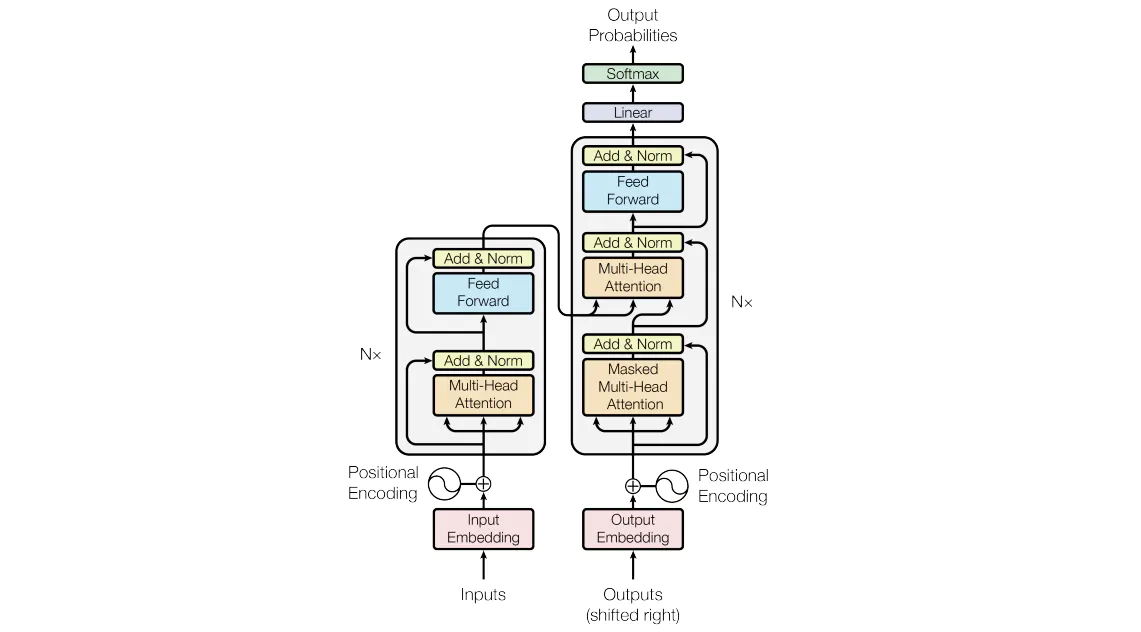

### 基本的なAttention
attentionの基本はqueryによってmemory(key, value)から必要な情報を選択的に引っ張ってくること    
queryはkeyによって取得するmemoryを決定し，対応するvalueを取得する  
これがRNNによるEncoder-Decoderモデルと同様の効果をもたらす  
  
まずは基本的なAttentionネットワークを作ってみる  
白丸がテンソル，灰四角がレイヤ
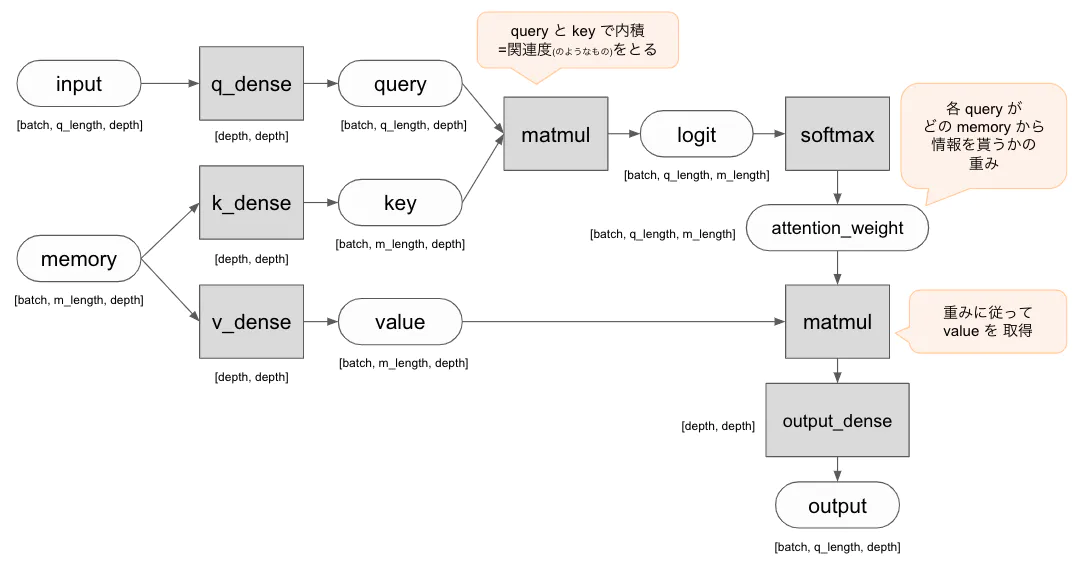

以降，行列のタテヨコは2次元配列をprintしたときの方向とする

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from typing import List, Tuple
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

class SimpleAttention(tf.keras.models.Model): # ネットワークの基礎モジュール
    ''' Simple Single Head Attention '''
    
    def __init__(self, depth: int, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.depth = depth # 分散表現ベクトルの次元数(ヨコ)
        
        self.q_dense_layer = Dense(depth, use_bias=False, name='q_dense_layer')
        self.k_dense_layer = Dense(depth, use_bias=False, name='k_dense_layer')
        self.v_dense_layer = Dense(depth, use_bias=False, name='v_dense_layer')
        self.output_dense_layer = Dense(depth, use_bias=False, name='output_dense_layer')
    
    def call(self, inputs: tf.Tensor, memory: tf.Tensor) -> tf.Tensor: # forward
        q = self.q_dense_layer(inputs) # [batch, q_length, depth]
        k = self.k_dense_layer(memory) # [batch, m_length, depth]
        v = self.v_dense_layer(memory) # [batch, m_length, depth]
        
        # qとk(転置)の内積を取り，queryとkeyの関連度のようなものを計算
        logit = tf.matmul(q, k, transpose_b=True) # [batch, q_length, m_length]
        
        # softmaxを取り正規化
        attention_weight = tf.nn.softmax(logit, name='attention_weight')
        
        # 重みに従ってvalueから情報を引いてくる
        attention_output = tf.matmul(attention_weight, v) # [batch, q_length, depth]
        
        return self.output_dense_layer(attention_output)

attention_weightはqueryがmemoryのどこからどれくらい情報を引いてくるかをkeyとの関連度から取得した値で，queryとkeyの行列積(matmul)で計算する  
Softmaxでquery(ヨコ，単語)ごとのweightの合計を1にするよう規格化している  
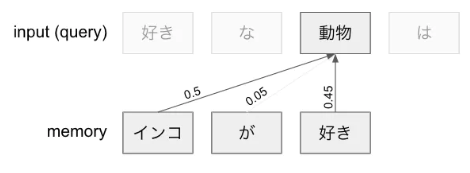

そしてattention_weightとvalueの行列積を取る．  
上図の例だと，`attn(動物) = value(インコ) * 0.5 + value(が) * 0.05 + value(好き) * 0.45`  
ここで，`attn(動物)`は「動物」のところのAttentionの出力ベクトル(ヨコ)  
これで得られたベクトルをさらにDenseで変換したものがこのレイヤーの出力

別の書き方をするとこんな感じ  
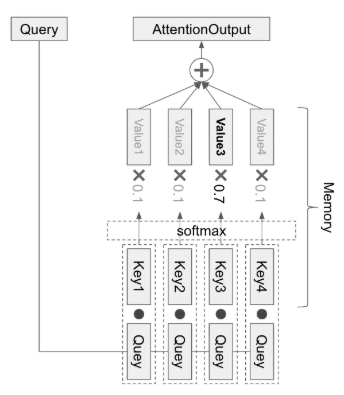

### Attentionの使い方
このAttentionには大きく2つの使い方がある  

#### Self-Attention
input, memory(key, value)のすべてに同じTensorを使うAttention  
言語の文保構造，指示語(itとか)対応などの照応関係を獲得するのに使えそう  
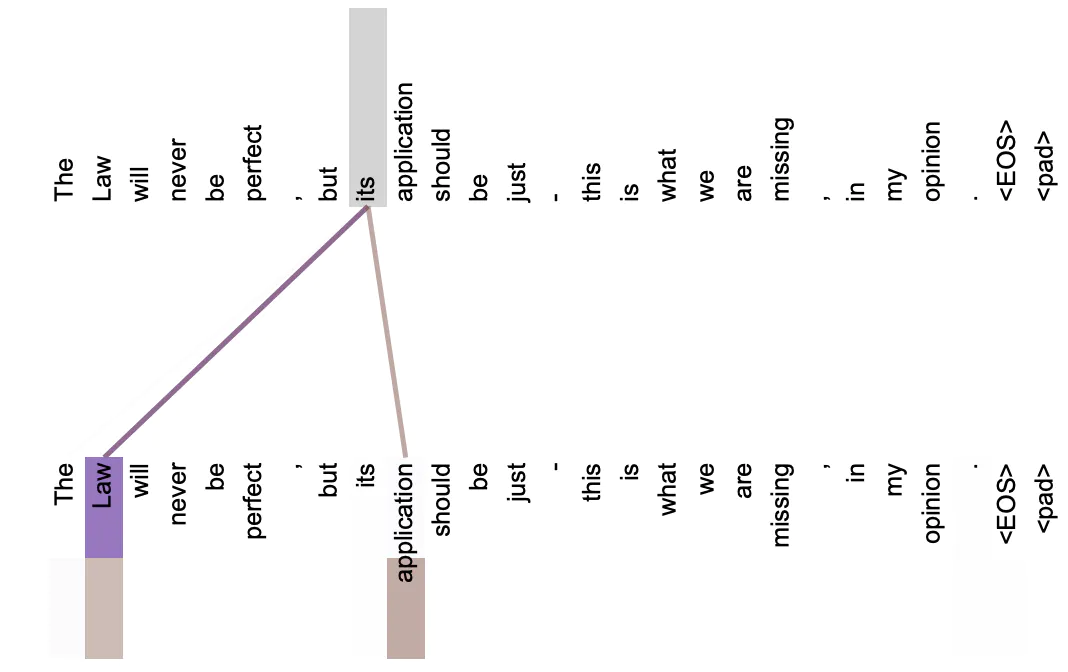
上段のqueryのitsに対してLowが対応していることが分かる  
Self-Attentionは汎用的に使える強力な仕組みである

#### SourceTarget-Attention
inputとmemory(key,value)が別々のTensorを使うAttention  
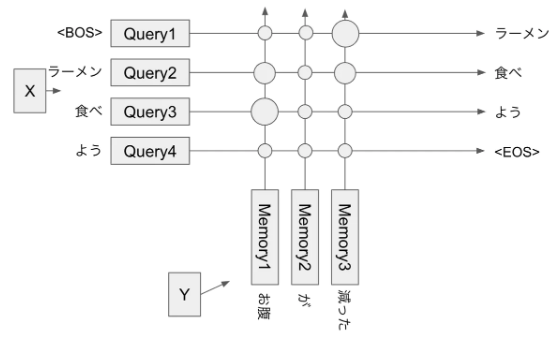

ある時刻tのトークンを受け取って過去の発話を基にt+1のトークンを予測  
ラーメン -> 「お腹が減った」のmemoryを受け取る -> 食べ -> ...  
のようにして文章全体を作り出す

もっとダイレクトに，queryを質問，memoryは応答の候補とし，queryに一番関係ありそうな応答から情報を引いてくるものもある  
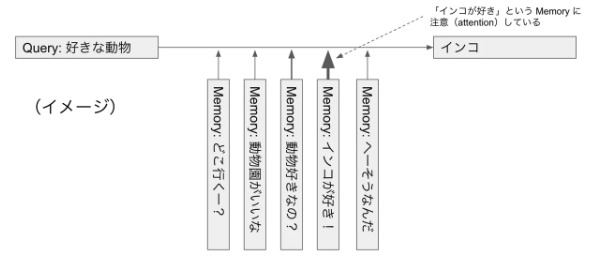

ここから先では，基本のAttentionの学習をうまくいくようにする工夫を紹介

### Scaled Dot-production
Softmax関数はlogitの値が大きいと分母が大きくなりすぎ，勾配が0に近くなってしまう  
logitは行列積なので，分散表現の次元数depthが大きいほどlogitも大きくなってしまう  
そこで，queryの大きさをdepthに従って小さくする  
$$ attention\_weight = softmax\Big( \frac{qk^\top}{\sqrt{depth}} \Big) $$
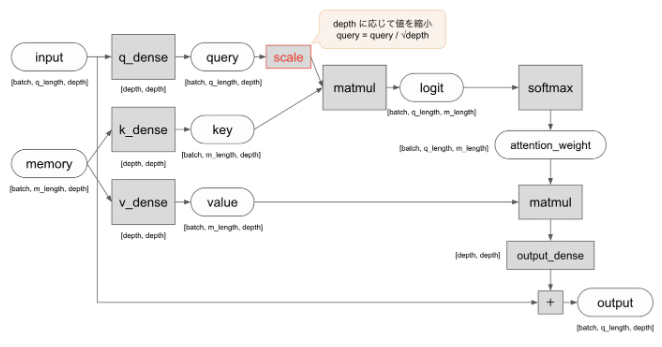

``` python
q *= depth ** -0.5
logit = tf.matmul(q, k, transpose_b=True)
attention_weight = tf.nn.softmax(logit, name='attention_weight')
```

### Mask
次のような場合，特定のkeyに対してattention_weightを0にしたい
- PADを無視したい
- DecoderのSelf-Attentionで未来の情報を参照できないようにしたい

attention_weightはSoftmaxの出力なので，その入力であるlogitのmaskしたい要素を-∞にする  
$$ softmax_i = \frac{e^{x_i}}{\sum_j e^{x_j}} $$
$$ e^{-\infty} = 0 $$

``` python
logit = tf.matmul(q, k, transposeb=True)
logit += tf.to_float(attention_mask) * inputs.dtype.min
attention_weight = tf.nn.softmax(logit, name='attention_weight')
```
ここでattention_maskは[batch, q_length, m_length]で，0にしたい部分がTrueであとFalse

#### PADを無視したい
一般的に入力する文章の長さはバラバラである  
長さをそろえるため，最大の単語数を設定し，それに足りていない分にPADを入れる  
そのPADには着目しないでほしいため，attention_weightを0にする  
例えば，memory = `おはよう / <PAD> / <PAD>`に対するmaskは次のようになる  
``` python
[[False, True, True],
 [False, True, True],
 [False, True, True],
 [False, True, True]]
```
これらのmaskの作り方は最後の全体コードに載せる

#### DecoderのSelf-Attentionで未来の情報を参照できないようにしたい
Decoderはある時刻tの入力からt+1を予測することを繰り返す(自己回帰)  
このとき，予測対象の未来の情報が得られてしまうと困るので，隠す  
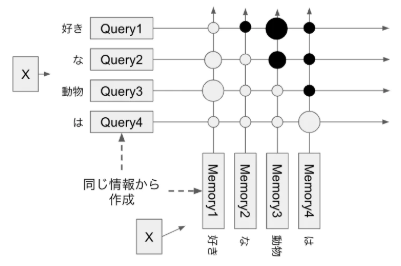  
この場合，maskは次のようになる
``` python
[[False, True,  True,  True],
 [False, False, True,  True],
 [False, False, False, True],
 [False, False, False, False]]
```

### Multi-head Attention
1つの大きなAttentjonを扱うより小さな複数のHeadに分けてAttentionする方が経験的に性能が上がるらしい  
query, key, valueをそれぞれhead_num個にsplitしてからそれぞれ計算，最後にconcatする  
ここで，分割するのは埋め込みベクトルの次元の方向であることに注意する  
ex. 単語埋め込みベクトルの長さが768  
-> 12個に分割し，埋め込みベクトルの長さは64になる
  
以上，これまでの
- Simple Attention
- Scaled Dot-production
- Mask
- Multi-head Attention

を組み合わせ，以降の基礎となる次のようなMultiheadAttentionモジュールを作成する  
さらに，随所にDropoutを追加することで汎化性能を上げられる(過学習を防ぐ?)のでそれもやる

In [3]:
class MultiheadAttention(tf.keras.models.Model):
    def __init__(self, hidden_dim: int, head_num: int, dropout_rate: float, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.hidden_dim = hidden_dim
        self.head_num = head_num
        self.dropout_rate = dropout_rate
        
        self.q_dense_layer = Dense(hidden_dim, use_bias=False, name="q_dense_layer")
        self.k_dense_layer = Dense(hidden_dim, use_bias=False, name="k_dense_layer")
        self.v_dense_layer = Dense(hidden_dim, use_bias=False, name="v_dense_layer")
        self.output_dense_layer = Dense(hidden_dim, use_bias=False, name="output_dense_layer")
        self.attention_dropout_layer = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, inputs: tf.Tensor, memory: tf.Tensor, attention_mask: tf.Tensor, training: bool) -> tf.Tensor:
        
        q = self.q_dense_layer(inputs)
        k = self.k_dense_layer(memory)
        v = self.v_dense_layer(memory)
        
        q = self._split_head(q)
        k = self._split_head(k)
        v = self._split_head(v)
        
        depth = self.hidden_dim // self.head_num
        q *= depth ** -0.5 # for scaled dot production
        
        logit = tf.matmul(q, k, transpose_b=True) # [batch, head_num, q_length, hidden_dim/head_num]
        logit += tf.to_float(attention_mask) * inputs.dtype.min # padを適用
        
        # softmaxで正規化＋dropout
        attention_weight = tf.nn.softmax(logit, name='attention_weight')
        attention_weight = self.attention_dropout_layer(attention_weight, training=training)
        
        # 重みに従ってvalueから情報を引いてくる＋multi-headを結合
        attention_output = tf.matmul(attention_weight, v) # [batch, head_num, q_length, hidden_dim/head_num]
        attention_output = self._combine_head(attention_output) # [batch, q_length, hidden_dim]
                
        return self.output_dense_layer(attention_output)
    
    def _split_head(self, x: tf.Tensor) -> tf.Tensor:
        ''' [batch, q_len, hidden_dim] -> [batch, head_num, q_len, hidden_dim // head_dim] '''
        with tf.name_scope('split_head'):
            batch_size, length, hidden_dim = tf.unstack(tf.shape(x))
            
            # 埋め込みベクトルの次元を8個に分割
            x = tf.reshape(x, [batch_size, length, self.head_num, self.hidden_dim // self.head_num])
            
            # 12個に分割した次元をバッチの下に持ってきたいのでtranspose
            # 下の2つの次元は単語数, 分割後の埋め込みベクトルの次元 となる
            return tf.transpose(x, [0, 2, 1, 3])
    
    def _combine_head(self, x: tf.Tensor) -> tf.Tensor:
        ''' [batch, head_num, q_len, hidden_dim // head_dim] -> [batch, q_len, hidden_dim] '''
        with tf.name_scope('combine_head'):
            batch_size, _, length, _ = tf.unstack(tf.shape(x))

            # split headと逆のことをする
            x = tf.transpose(x, [0, 2, 1, 3])
            return tf.reshape(x, [batch_size, length, self.hidden_dim])

Multi-head Attentionを継承し，Self Attentionを作る  
こちらは単にmemoryにinputを渡すだけ

In [4]:
class SelfAttention(MultiheadAttention):
    def call(self, inputs: tf.Tensor, attention_mask: tf.Tensor, training: bool) -> tf.Tensor:
        return super().call(inputs=inputs, memory=inputs, attention_mask=attention_mask, training=training)

### Hopping
Multi-head Attentionを何度も繰り返し適用することで，より複雑な学習ができる  
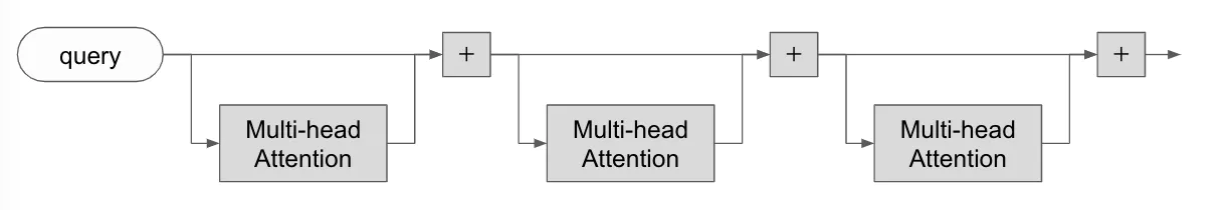
RNNと違って，各Attentionは独立した重みを持っている  
そのため，繰り返し回数は固定である  
これを可変にしたUniversal Transformerというモデルもある

### Position-wise Feedforward Network
各HoppingのAttentionの後にFFNを挟む  
一旦hidden_dim * 4に広げてからdropoutしてhidden_dimに戻して返す

In [5]:
class FeedForwardNetwork(tf.keras.models.Model):
    def __init__(self, hidden_dim: int, dropout_rate: float, *args, **kwargs) -> tf.Tensor:
        super().__init__(*args, **kwargs)
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        
        self.filter_dense_layer = Dense(hidden_dim * 4, use_bias=True, activation=tf.nn.relu, name='filter_layer')
        self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)
        self.output_dense_layer = Dense(hidden_dim, use_bias=True, name='output_layer')
    
    def call(self, inputs: tf.Tensor, training: bool) -> tf.Tensor:
        tensor = self.filter_dense_layer(inputs)
        tensor = self.dropout_layer(tensor, training=training)
        return self.output_dense_layer(tensor)

### LayerNormalization
画像処理系ではBatch Normalizationが有名  
各Batchの同じニューロンの出力で正規化する
入力の絶対値が各層の間で大きくなる時活性化関数の微分値が0になる問題を回避  
  
Transformerでは,Layer Normalizationを使う  
LNではBatchの中のデータごとに，同じ層の出力全てを正規化する  
batch_sizeに関わらず学習可能だが，CNNとの相性はあまりよくないらしい  

参考: [SlideShare LayerNormalization](https://www.slideshare.net/KeigoNishida/layer-normalizationnips), [QAサイト](https://www.quora.com/What-are-the-practical-differences-between-batch-normalization-and-layer-normalization-in-deep-neural-networks)  
tf.kerasに実装がないので自前で作る

In [6]:
class LayerNormalization(tf.keras.layers.Layer):
    def build(self, input_shape: tf.TensorShape) -> None:
        hidden_dim = input_shape[-1]
        self.scale = self.add_weight('layer_norm_scale', shape=[hidden_dim], initializer=tf.ones_initializer())
        self.bias = self.add_weight('layer_norm_bias', shape=[hidden_dim], initializer=tf.zeros_initializer())
    
    def call(self, x: tf.Tensor, epsilon: float = 1e-6) -> tf.Tensor:
        mean = tf.reduce_mean(x, axis=[-1], keepdims=True)
        variance = tf.reduce_mean(tf.square(x - mean), axis=[-1], keepdims=True)
        norm_x = (x - mean) * tf.rsqrt(variance + epsilon) # rsqrt: ルートとって逆数
        return norm_x * self.scale + self.bias # x*1+0なので特に何かするわけでもない

## ResidualNormalizationWrapper
TransformerはLayerNorm, Dropoutを施し，Residualするところが各所にある  
任意の層を入力したら上記の層をWrapする層を作成  
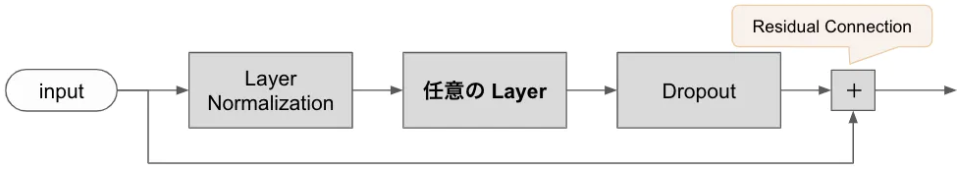

In [7]:
class ResidualNormalizationWrapper(tf.keras.models.Model):
    def __init__(self, layer: tf.keras.layers.Layer, dropout_rate: float, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layer = layer
        self.layer_normalization = LayerNormalization()
        self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, inputs: tf.Tensor, training: bool, *args, **kwargs):
        tensor = self.layer_normalization(inputs)
        tensor = self.layer(tensor, training=training, *args, **kwargs)
        tensor = self.dropout_layer(tensor, training=training)
        return inputs + tensor

## Positional Encoding
各単語の相対的な位置による値を学習するため，Positional Encodingを加算する  
$$ PE_{(pos, 2i)} = \sin \Big( \frac{pos}{10000^{2i/d_{model}}} \Big) $$
$$ PE_{(pos, 2i+1)} = \cos \Big( \frac{pos}{10000^{2i/d_{model}}} \Big) $$
- pos: 時刻(何単語目か)
- 2i, 2i+1: Embeddingの何番目の次元か

この数式によって，相対的な位置$PE_{pos+k}$を$PE_{pos}$で表すことができる  
そのため，ニューラルネットが相対的な位置関係を学習しやすいはず，とのこと

偶数番目の次元について試しに計算してみる  
$u_i = \frac{1}{10000^{2i/d_{model}}}$ とすると，  
$PE_{p, 2i} = \sin(pu_i), PE_{p, 2i+1} = \cos(pu_i)$  
このとき，  
$$ PE_{p+k, 2i} = \sin((p+k)u_i) = \sin(p_ui) $$
$$ = \sin(pu_i)\cos(ku_i) + \cos(pu_i)\sin(ku_i) $$
(咲いたコスモスコスモス咲いた)
$$ = PE_{p, 2i}\cos(ku_i) + PE_{p, 2i+1}\sin(ku_i) $$
以上のようにして，相対位置$PE_{p+k, 2i}$を$PE_{p, 2i}$と$PE_{p, 2i+1}$の線形和で表すことができる  
しかしPEは必ずしもこの形である必要はなく，BERTでは学習で獲得するようにしているようなこともある  
  
実装は本家のコードとは異なるが，以下のようになる  
要はsinに対応するcosがどこかにあればいいので，本家実装では並び方がsin, cos, sin, cos ...ではなく，sin, sin, cos, cos, ...となっている  
$\cos(x) = \sin(x+\pi/2)$を利用してsinからcosを作ることで簡潔なコードになる  

In [8]:
import math

class AddPositionalEncoding(tf.keras.layers.Layer):
    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        fl_type = inputs.dtype
        batch_size, max_length, depth = tf.unstack(tf.shape(inputs)) # depth: 埋め込みベクトルの長さ
        
        # u_iを作成
        depth_counter = tf.range(depth) // 2 * 2  # 0, 0, 2, 2, 4, 4, ...
        # 次元を1つ増やし，[max_length, 1]回繰り返す
        depth_matrix = tf.tile(tf.expand_dims(depth_counter, 0), [max_length, 1])
        depth_matrix = tf.pow(10000.0, tf.cast(depth_matrix / depth, fl_type))
        # [max_length, depth]
        
        # cos(x) == sin(x + Π/2) を利用し，sinかcosかを決めるphase行列を作成
        phase = tf.cast(tf.range(depth) % 2, fl_type) * math.pi / 2  # 0, Π/2, 0, Π/2, ...
        phase_matrix = tf.tile(tf.expand_dims(phase, 0), [max_length, 1])
        # [max_length, depth]
        
        # posを作成
        pos_counter = tf.range(max_length) # 0, 1, 2, 3, ...
        pos_matrix = tf.cast(tf.tile(tf.expand_dims(pos_counter, 1), [1, depth]), fl_type)
        # [max_length, depth]
        
        # 上記3つとsin関数でpositional_encodingを作成し，全batch分作成
        positional_encoding = tf.sin(pos_matrix / depth_matrix + phase_matrix)
        positional_encoding = tf.tile(tf.expand_dims(positional_encoding, 0), [batch_size, 1, 1])
        # [batch, max_length, depth]
        
        return inputs + positional_encoding

### Token Embedding
tf.nn.embedding_lookupを用いて単語IDを埋め込みベクトルに変換  
本家のコードでは最後に埋め込みベクトルの長さのルートで割ってスケールしている

In [9]:
PAD_ID = 0

class TokenEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size: int, embedding_dim: int, dtype=tf.float32, *args, **kwargs):
        super().__init__(*args, *kwargs)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.dtype_ = dtype
    
    def build(self, input_shape: tf.TensorShape):
        self.lookup_table = self.add_variable(
            name='token_embedding',
            shape=[self.vocab_size, self.embedding_dim],
            dtype=self.dtype_,
            initializer=tf.random_normal_initializer(0., self.embedding_dim ** -0.5)
        )
        super().build(input_shape)
    
    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        mask = tf.to_float(tf.not_equal(inputs, PAD_ID)) # PAD_IDのところは0，それ以外は1になる
        embedding= tf.nn.embedding_lookup(self.lookup_table, inputs) # dimが1つ増える
        embedding *= tf.expand_dims(mask, -1) # PADのところを0にする．dim数だけ合わせる
        return embedding * self.embedding_dim ** 0.5 # 長さのルートでスケーリング

ここまでで細かい部品が完成！

## Encoder
TransformerはEncoderとDecoderからなる  
Encoderは，Self-Attentionで入力トークン列をエンコードする  
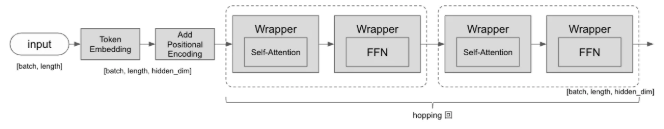

In [10]:
class Encoder(tf.keras.models.Model):
    def __init__(self, 
                 vocab_size: int, 
                 hopping_num: int, 
                 head_num: int, 
                 hidden_dim: int, 
                 dropout_rate: float,
                 max_length: int,
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.hopping_num = hopping_num
        self.head_num = head_num
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        
        self.token_embedding = TokenEmbedding(vocab_size, hidden_dim)
        self.add_position_embedding = AddPositionalEncoding()
        self.input_dropout_layer = tf.keras.layers.Dropout(dropout_rate)
        
        self.attention_block_list: List[List[tf.keras.models.Model]] = []
        for _ in range(hopping_num):
            attention_layer = SelfAttention(hidden_dim, head_num, dropout_rate, name = 'self_attention')
            ffn_layer = FeedForwardNetwork(hidden_dim, dropout_rate, name='ffn')
            self.attention_block_list.append([
                ResidualNormalizationWrapper(attention_layer, dropout_rate, name='self_attention_wrapper'),
                ResidualNormalizationWrapper(ffn_layer, dropout_rate, name='ffn_wrapper')
            ])
        self.output_normalization = LayerNormalization()
    
    def call(self,
             inputs: tf.Tensor,
             self_attention_mask: tf.Tensor,
             training: bool) -> tf.Tensor:
        # [batch, length]
        
        embedded_input = self.token_embedding(inputs)
        embedded_input = self.add_position_embedding(embedded_input)
        query = self.input_dropout_layer(embedded_input, training=training)
        # [batch, length, hidden_dim]
        
        for i, layers in enumerate(self.attention_block_list):
            attention_layer, ffn_layer = tuple(layers)
            with tf.name_scope(f'hopping_{i}'):
                query = attention_layer(query, attention_mask=self_attention_mask, training=training)
                query = ffn_layer(query, training=training)
                
        return self.output_normalization(query)

### 参考: Attentionベースの識別器
NLPの多くは文書識別タスクであり，そのためにはEncoderだけあればよい  
BERTでは，このEncoderに一層DenseLayerをかぶせることで実現している  
- Encoderへの入力の最初(時刻0)に`<CLS>`というトークンを入れる
- Encoderからの出力の`<CLS`>の位置の出力のみを取り出す
- これにDenseLayerをかぶせて識別したいクラスの数の次元に変換
- softmaxをかけたりcross entropyでロスを取得する

``` python
encoder_output = self.encoder_layer(...)
cls_vector = encoder_output[:, 0, :] # CLSは0番目に設定されている
classification_logit = self.dense_layer(cls_vector)
prob = tf.nn.softmax(classification_logit)
```
BERTでは識別器に複数の文を入れるため，さらに`<SEP>`を導入している

## Decoder
Decoderは入力にSelf－AttentionをかけてからSourceTarget-AttentionでEncoderがエンコードした情報を取り込む  
これによって時刻0～tの単語列を入力として，時刻1～t+1のトークン列を出力する  
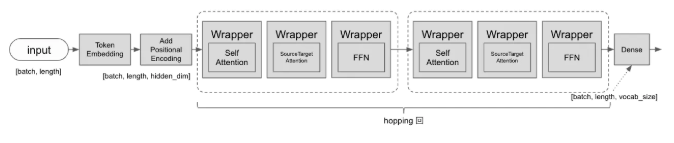

In [11]:
class Decoder(tf.keras.models.Model):
    def __init__(self,
                vocab_size: int,
                hopping_num: int,
                head_num: int,
                hidden_dim: int,
                dropout_rate: float,
                max_length: int,
                *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.hopping_num = hopping_num
        self.head_num = head_num
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        
        self.token_embedding = TokenEmbedding(vocab_size, hidden_dim)
        self.add_position_embedding = AddPositionalEncoding()
        self.input_dropout_layer = tf.keras.layers.Dropout(dropout_rate)
        
        self.attention_block_list: List[List[tf.keras.models.Model]] = []
        for _ in range(hopping_num):
            self_attention_layer = SelfAttention(hidden_dim, head_num, dropout_rate, name='self_attention')
            enc_dec_attention_layer = MultiheadAttention(hidden_dim, head_num, dropout_rate, name='enc_dec_attention')
            ffn_layer = FeedForwardNetwork(hidden_dim, dropout_rate, name='ffn')
            self.attention_block_list.append([
                ResidualNormalizationWrapper(self_attention_layer, dropout_rate, name='self_attention_wrapper'),
                ResidualNormalizationWrapper(enc_dec_attention_layer, dropout_rate, name='enc_dec_attention_wrapper'),
                ResidualNormalizationWrapper(ffn_layer, dropout_rate, name='ffn_wrapper')
            ])
        self.output_normalization = LayerNormalization()
        self.output_dense_layer = Dense(vocab_size, use_bias=False)
    
    def call(self,
            inputs: tf.Tensor,
            encoder_output: tf.Tensor,
            self_attention_mask: tf.Tensor,
            enc_dec_attention_mask: tf.Tensor,
            training: bool):
        embedded_input = self.token_embedding(inputs)
        embedded_input = self.add_position_embedding(embedded_input)
        query = self.input_dropout_layer(embedded_input, training=training)
        
        for i, layers in enumerate(self.attention_block_list):
            self_attention_layer, enc_dec_attention_layer, ffn_layer = tuple(layers)
            with tf.name_scope(f'hopping_{i}'):
                query = self_attention_layer(query, attention_mask=self_attention_mask, training=training)
                query = enc_dec_attention_layer(query, memory=encoder_output, attention_mask=enc_dec_attention_mask, training=training)
                query = ffn_layer(query, training=training)
        
        query = self.output_normalization(query) # [batch, length, hidden_dim]
        return self.output_dense_layer(query) # [batch, length, vocab_size]

## 全体像
最後にEncoder, DecoderをつなげるとTransformerの完成  
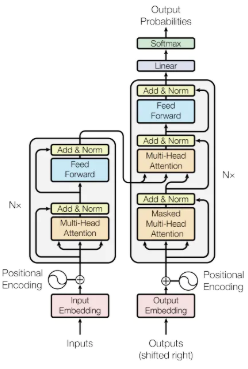

In [12]:
# copy from https://github.com/tensorflow/models/blob/master/official/transformer/utils/metrics.py

def padded_cross_entropy_loss(logits, labels, smoothing, vocab_size):
    """Calculate cross entropy loss while ignoring padding.
    Args:
      logits: Tensor of size [batch_size, length_logits, vocab_size]
      labels: Tensor of size [batch_size, length_labels]
      smoothing: Label smoothing constant, used to determine the on and off values
      vocab_size: int size of the vocabulary
    Returns:
      Returns the cross entropy loss and weight tensors: float32 tensors with
        shape [batch_size, max(length_logits, length_labels)]
    """
    with tf.name_scope("loss", values=[logits, labels]):        
        logits, labels = _pad_tensors_to_same_length(logits, labels)
        
        # Calculate smoothing cross entropy
        with tf.name_scope("smoothing_cross_entropy", values=[logits, labels]):
            confidence = 1.0 - smoothing
            low_confidence = (1.0 - confidence) / tf.to_float(vocab_size - 1)
            soft_targets = tf.one_hot(
                tf.cast(labels, tf.int32),
                depth=vocab_size,
                on_value=confidence,
                off_value=low_confidence)
            xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(
                logits=logits, labels=soft_targets)

            # Calculate the best (lowest) possible value of cross entropy, and
            # subtract from the cross entropy loss.
            normalizing_constant = -(
                confidence * tf.log(confidence) + tf.to_float(vocab_size - 1) *
                low_confidence * tf.log(low_confidence + 1e-20))
            xentropy -= normalizing_constant

        weights = tf.to_float(tf.not_equal(labels, 0))
        return xentropy * weights, weights


def padded_accuracy(logits, labels):
    """Percentage of times that predictions matches labels on non-0s."""
    with tf.variable_scope("padded_accuracy", values=[logits, labels]):
        logits, labels = _pad_tensors_to_same_length(logits, labels)
        weights = tf.to_float(tf.not_equal(labels, 0))
        outputs = tf.to_int32(tf.argmax(logits, axis=-1))
        padded_labels = tf.to_int32(labels)
        return tf.to_float(tf.equal(outputs, padded_labels)), weights


def _pad_tensors_to_same_length(x, y):
    """Pad x and y so that the results have the same length (second dimension)."""
    with tf.name_scope("pad_to_same_length"):
        x_length = tf.shape(x)[1]
        y_length = tf.shape(y)[1]

        max_length = tf.maximum(x_length, y_length)

        x = tf.pad(x, [[0, 0], [0, max_length - x_length], [0, 0]])
        y = tf.pad(y, [[0, 0], [0, max_length - y_length]])
        return x, y

In [13]:
class Transformer(tf.keras.models.Model):
    def __init__(self,
                vocab_size: int,
                hopping_num: int = 4,
                head_num: int = 8,
                hidden_dim: int = 512,
                dropout_rate: float = 0.1,
                max_length: int = 200,
                *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.vocab_size = vocab_size
        self.hopping_num = hopping_num
        self.head_num = head_num
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        self.max_length = max_length
        
        self.encoder = Encoder(
            vocab_size=vocab_size,
            hopping_num=hopping_num,
            head_num=head_num,
            hidden_dim=hidden_dim,
            dropout_rate=dropout_rate,
            max_length=max_length
        )
        
        self.decoder = Decoder(
            vocab_size=vocab_size,
            hopping_num=hopping_num,
            head_num=head_num,
            hidden_dim=hidden_dim,
            dropout_rate=dropout_rate,
            max_length=max_length
        )
        
    def build_graph(self, name='transformer'):
        with tf.name_scope(name):
            self.is_training = tf.placeholder(dtype=tf.bool, name='is_training')
            
            self.encoder_input = tf.placeholder(dtype=tf.int32, shape=[None, None], name='encoder_input')
            
            self.decoder_input = tf.placeholder(dtype=tf.int32, shape=[None, None], name='decoder_input')
            
            logit = self.call(
                encoder_input = self.encoder_input,
                decoder_input = self.decoder_input[:, :-1], # 入力は EOS を含めない
                training=self.is_training
            )
            decoder_target = self.decoder_input[:, 1:] # 出力は BOS を含めない
            
            self.prediction = tf.nn.softmax(logit, name='prediction')
            
            with tf.name_scope('metrics'):
                # 単純なone-hotではなく，label smoothingで少しなまらせる
                xentropy, weights = padded_cross_entropy_loss(
                    logit, decoder_target, smoothing=0.05, vocab_size=self.vocab_size
                )
                
                # 名前を付けるために?identityをかませる
                self.loss = tf.identity(tf.reduce_sum(xentropy) / tf.reduce_sum(weights), name='loss')
                
                accuracies, weights = padded_accuracy(logit, decoder_target)
                self.acc = tf.identity(tf.reduce_sum(accuracies) / tf.reduce_sum(weights), name='acc')
    
    def call(self, encoder_input: tf.Tensor, decoder_input: tf.Tensor, training: bool) -> tf.Tensor:
        enc_attention_mask = self._create_enc_attention_mask(encoder_input)
        dec_self_attention_mask = self._create_dec_self_attention_mask(decoder_input)
        
        encoder_output = self.encoder(
            encoder_input,
            self_attention_mask=enc_attention_mask,
            training=training
        )
        
        decoder_output = self.decoder(
            decoder_input,
            encoder_output,
            self_attention_mask=dec_self_attention_mask,
            enc_dec_attention_mask=enc_attention_mask,
            training=training
        )
        
        return decoder_output
        
    def _create_enc_attention_mask(self, encoder_input: tf.Tensor):
        with tf.name_scope('enc_attention_mask'):
            batch_size, length = tf.unstack(tf.shape(encoder_input))
            pad_array = tf.equal(encoder_input, PAD_ID) # [batch, m_length]
            # shape broadcastingでpad_arrayに合わせて[batch, head_num, (m|q)length, m_length]になる
            return tf.reshape(pad_array, [batch_size, 1, 1, length])
    
    def _create_dec_self_attention_mask(self, decoder_input: tf.Tensor):
        with tf.name_scope('enc_attention_mask'):
            batch_size, length = tf.unstack(tf.shape(decoder_input))
            pad_array = tf.equal(decoder_input, PAD_ID) # [batch, m_length]
            pad_array = tf.reshape(pad_array, [batch_size, 1, 1, length])

            # 未来の情報を取得させない
            autoregression_array = tf.logical_not(
                tf.matrix_band_part(tf.ones([length, length], dtype=tf.bool), -1, 0) # 下三角がFalse
            )
            autoregression_array = tf.reshape(autoregression_array, [1, 1, length, length])
            
            return tf.logical_or(pad_array, autoregression_array)

## Transformerを学習させる
実験タスクは，「小説の各文の次の文を予測する」こと

### データの準備
青空文庫から落としてきた夏目漱石の文章を使う  
文章から非文部分を除き，文ごとに改行が入っている  
雑らしいので「」内でも分割されてしまっている  
https://github.com/halhorn/deep_dialog_tutorial/tree/master/data

### トークナイザー
文章を適当なトークンに区切り，ID化する  
色々方法があるが，ここでは[sentencepiece](https://qiita.com/taku910/items/7e52f1e58d0ea6e7859c)を使う  
サブワード: 高頻度な単語はそのまま1つの単語に，低頻度の単語はさらに分割する  
これにより，未知語が実質なくなる  
教師なし学習による可逆分割なサブワードの拡張がsentencepiece  

インストール手順は[Githubを参照](https://github.com/google/sentencepiece)した  
``` bash
% sudo apt-get install cmake build-essential pkg-config libgoogle-perftools-dev -y
% git clone https://github.com/google/sentencepiece.git
% cd sentencepiece
% mkdir build
% cd build
% cmake ..
% make -j $(nproc)
% sudo make install
% sudo ldconfig -v
```

`spm_train`コマンドを使ってコーパスを学習し，spm_natsume.modelを作成
``` bash
$ spm_train --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3 --input=path/to/natsume.txt \
  --model_prefix=path/to/spm_natsume --vocab_size=8000 --hard_vocab_limit=false
```
vocab_sizeが大きくてコーパスが小さいとunrecoverable errorが発生する．  
エラーが出ないギリギリを攻めていく必要があった．  
しかし，`hard_vocab_limit=false`を設定することで，ギリギリのvocab_sizeに自動で直してくれるようになった  
  
加えて，sentencepieceのPython拡張を導入する
``` bash
$ pip install sentencepiece
```


### バッチ作成モジュール
学習用のバッチを作成  
1. 文章をトークナイザーでID列に変換
1. 決められた長さで切り詰める
1. Decoderへの入力データは前後にbosとeosを入れる
1. バッチ内の各ID列の長さをpadで最大のものにそろえる
1. numpy arrayにする

In [14]:
import sentencepiece as spm
import numpy as np
import random
from typing import List, Sequence, Tuple

ENCODER_INPUT_NODE = 'transformer/encoder_input:0'
DECODER_INPUT_NODE = 'transformer/decoder_input:0'
IS_TRAINING_NODE = 'transformer/is_training:0'

spm_model_path = os.path.join(natsume_dir, 'spm_natsume.model')
data_path = os.path.join(natsume_dir, 'natsume.txt')

class BatchGenerator:
    def __init__(self,
                max_length=50,
                spm_model_path: str = spm_model_path):
        self.max_length = max_length
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(spm_model_path)
        self.bos = self.sp.piece_to_id('<s>')
        self.eos = self.sp.piece_to_id('</s>')
        self.pad = 0
    
    @property
    def vocab_size(self) -> int:
        return self.sp.get_piece_size()
    
    @property
    def data_size(self):
        return {
            "all": self.data_len,
            "train": self.train_data_len,
            "val": self.val_data_len,
            "test": self.test_data_len
        }
    
    def ids_to_sentence(self, sentence, separator=' '):
        return separator.join([self.sp.id_to_piece(int(idx)) for idx in sentence])

    
    def load(self, file_path: str = data_path, val_rate=0.2, test_rate=0.01, shuffle=True, seed=None):
        ''' 
            ファイルを読み，各行をstripして処理
            処理済みデータをインスタンスに保持する
        '''
        with open(file_path) as f:
            lines = [line.strip() for line in f.readlines()]
            
        self.data_len = len(lines)
        self.train_data_len = int(self.data_len * (1 - val_rate - test_rate))
        self.val_data_len = int(self.data_len * val_rate)
        self.test_data_len = int(self.data_len * test_rate)
        
        self.data = self._create_data(lines)
        
        if shuffle:
            if seed is not None:
                random.seed(seed)
            random.shuffle(self.data)
        
        self.data_dict = {
            'train': self.data[:self.train_data_len],
            'val': self.data[self.train_data_len:self.train_data_len+self.val_data_len],
            'test': self.data[-self.test_data_len:]
        }
        
    
    def _create_data(self, lines: Sequence[str]) -> List[Tuple[List[int], List[int]]]:
        ''' 
            questions: 入力， answers: ラベル 
            次の文を予測するため，1つずらして渡す
        '''
        questions = [self._create_question(line) for line in lines[:-1]]
        answers = [self._create_answer(line) for line in lines[1:]]
        return list(zip(questions, answers))
    
    def _create_question(self, sentence) -> List[int]:
        ''' 単語をIDトークン化し， max_lengthで切る '''
        ids = self.sp.encode_as_ids(sentence)
        return ids[:self.max_length]

    def _create_answer(self, sentence: str) -> List[int]:
        ''' 単語をIDトークン化し， bos, eosを含めてmax_lengthで切る '''
        ids = self.sp.encode_as_ids(sentence)
        return [self.bos] + ids[:self.max_length - 2] + [self.eos]


    
    def get_batch(self, batch_size: int = 128, phase='train', shuffle=True, seed=None):
        ''' 
            phaseのBatchのGeneratorを取得
            バッチは辞書オブジェクトとしてyieldされる
        '''
        data = self.data_dict[phase]
        
        if shuffle:
            if seed is not None:
                random.seed(seed)
            random.shuffle(data)
        
        raw_batch_list = self._split(data, batch_size)
        for raw_batch in raw_batch_list:
            questions, answers = zip(*raw_batch)
            yield {
                ENCODER_INPUT_NODE: self._convert_to_array(questions),
                DECODER_INPUT_NODE: self._convert_to_array(answers),
                IS_TRAINING_NODE: phase == 'train',
            }
    
    def _split(self, nd_list: Sequence, batch_size: int) -> List[List]:
        ''' データをバッチに分割 '''
        return [list(nd_list[i - batch_size:i]) for i in range(batch_size, len(nd_list) + 1, batch_size)]
    
    def _convert_to_array(self, id_list_list: Sequence[Sequence[int]]) -> np.ndarray:
        ''' padでmax_lengthに埋めつつndarrayへ変換 '''
        max_len = max([len(id_list) for id_list in id_list_list])
        return np.array(
            [list(id_list) + [self.pad] * (max_len - len(id_list)) for id_list in id_list_list],
            dtype=np.int32
        )

In [15]:
batch_generator = BatchGenerator()
batch_generator.load(data_path)
vocab_size = batch_generator.vocab_size
print(vocab_size)
print(batch_generator.data_size)

8000
{'all': 106067, 'train': 83792, 'val': 21213, 'test': 1060}


In [16]:
generator = batch_generator.get_batch(batch_size=10, phase='test')
batch = next(generator)
questions = batch[ENCODER_INPUT_NODE]
answers = batch[DECODER_INPUT_NODE]
training = batch[IS_TRAINING_NODE]

print('question:', questions.shape)
print('answer:', answers.shape)
print('training:', training)
print(batch_generator.ids_to_sentence(questions[1]))

question: (10, 29)
answer: (10, 43)
training: False
▁「 え ? こう やる と 誰でも さ っぱ りする からね 」 。 <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


## 学習を行う
ここまで作った部品を組み合わせて学習

モデルの計算グラフを作成  
Tensorflowでの計算の実行に入っていく  
[Tensorflow](https://www.buildinsider.net/small/booktensorflow/0001)はbuild_graphでC++による計算グラフを作成し，tf.Session().runによって裏で実行する  
その返り値が計算の結果となる  

graph.as_default: 計算グラフの変数名のスコープを作る．複数のモデルが一緒に動いても大丈夫  
[tf.Graphの使い所](https://qiita.com/n_kats_/items/6aa0fb4304da2e035400)

In [17]:
graph = tf.Graph()
with graph.as_default():
    transformer = Transformer(
        vocab_size=vocab_size,
        hopping_num=4,
        head_num=8,
        hidden_dim=512,
        dropout_rate=0.1,
        max_length=50
    )
    transformer.build_graph()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


モデルのほかに使用するオペレーションの作成

In [18]:
with graph.as_default():
    # ステップ数を数えるオペレーション
    global_step = tf.train.get_or_create_global_step()
    
    # stepに応じて変化させたいため，feed_dictで逐一受け取る
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    
    # パラメータ更新オペレーション．transformer.lossを与える
    optimizer = tf.train.AdamOptimizer(
        learning_rate=learning_rate,
        beta2=0.98
    )
    optimize_op = optimizer.minimize(transformer.loss, global_step=global_step)
    
    # 学習記録用オペレーション
    train_summary_op = tf.summary.merge([
        tf.summary.scalar('train/loss', transformer.loss),
        tf.summary.scalar('train/acc', transformer.acc),
        tf.summary.scalar('train/learning_rate', learning_rate)
    ], name='train_summary')
    
    val_summary_op = tf.summary.merge([
        tf.summary.scalar('val/loss', transformer.loss),
        tf.summary.scalar('val/acc', transformer.acc)
    ], name='val_summary')
    
    summary_op_dict = {
        'train': train_summary_op,
        'val': val_summary_op
    }
    
    summary_writer = tf.summary.FileWriter(log_dir, graph)
    
    saver = tf.train.Saver()

ハイパーパラメータ

In [19]:
max_step = 50000
batch_size = 200
max_learning_rate = 0.0001
warmup_step = 2000

動的にlearning_rateを決定する  
最初0から始めて徐々に増やしていき，warmup_step(4000)を境に減衰させる  
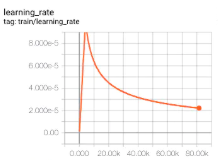

In [20]:
def get_learning_rate(step: int) -> float:
    rate = min(step ** -0.5, step * warmup_step ** -1.5) / warmup_step ** -0.5
    return max_learning_rate * rate

何もしないとSession.runによってGPU上のメモリを一気に10Gくらい勝手に確保しにいく  
必要に応じてメモリを確保したい場合は次のようにGPU Configを設定する  
CUDA_VISIBLE_DEVICE -> visible_device_listとしないと他のGPUにも謎の若干の負担をかけてしまうので注意  
参考：[TensorflowでGPUを制限・無効化する](https://qiita.com/kikusumk3/items/907565559739376076b9)

In [21]:
os.environ['CUDA_VISIBLE_DEVICES'] = "2" # 見えるのを2番だけにして
config = tf.ConfigProto(gpu_options=tf.GPUOptions(
    visible_device_list="0", # その中の0番目
    allow_growth=True
))

変数の初期化処理を行うセッションを作成  

In [22]:
with graph.as_default():
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    step = 0

学習と記録の実行

In [23]:
loss_dict = {'train': [], 'val': []}
acc_dict = {'train': [], 'val': []}
epoch = 1
with graph.as_default():
    while True:
        for phase in ['train', 'val']:
            
            if phase == 'val':
                print('start validation...')
            
            start = time.time()
            iteration, sum_loss, sum_acc = 0, 0, 0
            for batch in batch_generator.get_batch(batch_size=batch_size, phase=phase):

                # placeholderへ渡されるfeed dict
                feed = {
                    **batch,
                    learning_rate: get_learning_rate(step + 1) if phase == 'train' else 0
                }

                # 上から順番に計算グラフを実行していき，それぞれの値を返り値として受け取る
                if phase == 'train':
                    _, loss, acc, step, summary = sess.run([
                        optimize_op, 
                        transformer.loss, 
                        transformer.acc,
                        global_step,
                        summary_op_dict[phase]
                    ], feed_dict=feed)
                else:
                    loss, acc, summary = sess.run([
                        transformer.loss,
                        transformer.acc,
                        summary_op_dict[phase]
                    ], feed_dict=feed)

                summary_writer.add_summary(summary, step)
                sum_loss += loss
                sum_acc += acc
                iteration += 1

                if phase == 'train' and step % 100 == 0:
                    clear_output()
                    elapsed = time.time() - start

                    print(f'{step} / {max_step} | phase = train | loss: {loss:.5f} | acc: {acc:.5f} | time(100 steps): {elapsed:.2f} [sec]')
                    saver.save(sess, ckpt_path, global_step=step)

                    start = time.time()
            
            loss_dict[phase].append(sum_loss / iteration)
            acc_dict[phase].append(sum_acc / iteration)
            
            print(f'Average | epoch = {epoch} | phase = {phase} | loss: {loss_dict[phase][-1]:.5f} | acc: {acc_dict[phase][-1]:.5f}')
        
        epoch += 1
        if step >= max_step:
            break

50100 / 50000 | phase = train | loss: 1.84863 | acc: 0.57612 | time(100 steps): 36.12 [sec]
Average | epoch = 120 | phase = train | loss: 1.82429 | acc: 0.58812
start validation...
Average | epoch = 120 | phase = val | loss: 5.36186 | acc: 0.25113


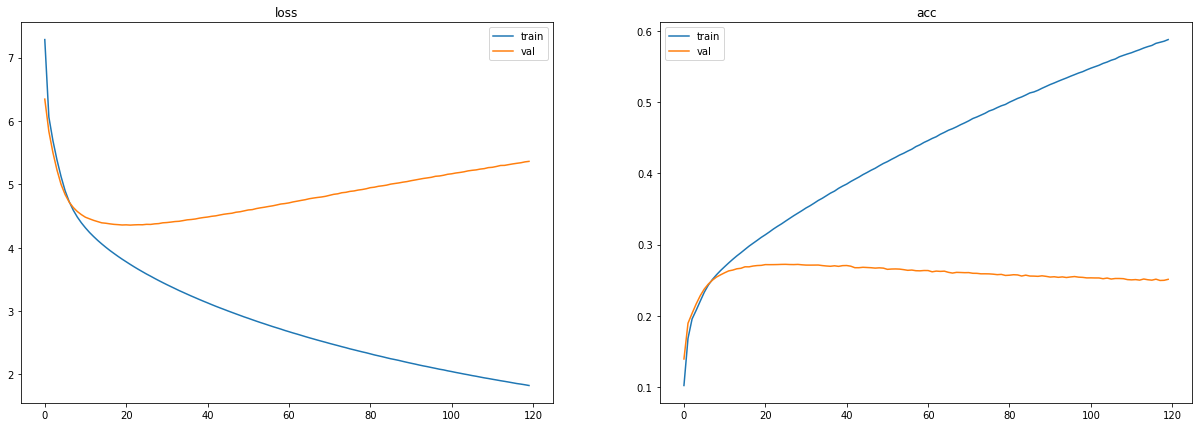

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(21, 7))
ax[0].plot(loss_dict['train'], label='train')
ax[0].plot(loss_dict['val'], label='val')
ax[0].legend()
ax[0].set_title('loss')
ax[1].plot(acc_dict['train'], label='train')
ax[1].plot(acc_dict['val'], label='val')
ax[1].legend()
ax[1].set_title('acc')
plt.show()

In [43]:
idx = 0

test_generator = batch_generator.get_batch(batch_size=100, phase='test', shuffle=False)
batch = next(generator)
questions = batch[ENCODER_INPUT_NODE]
answers = batch[DECODER_INPUT_NODE]

with graph.as_default():
    sess_test = tf.Session(config=config)
    sess_test.run(tf.global_variables_initializer())
    predicted = transformer.call(questions[idx:idx+1], answers[idx:idx+1], training=False)
    predicted = tf.to_int32(tf.argmax(predicted, axis=-1))
    result = sess_test.run(predicted)

print('question')
print(batch_generator.ids_to_sentence(questions[idx]))
print('answer')
print(batch_generator.ids_to_sentence(answers[idx]))
print('predicted')
print(batch_generator.ids_to_sentence(result[0]))

question
▁三四郎は この 表情 のうちに もの う い 憂 鬱 と 、 隠 さ ざる 快 活 と の 統一 を見 いだ した 。 <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
answer
<s> ▁その 統一 の 感じ は 三四郎 にとって 、 最も 尊 き 人生 の一 片 である 。 </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
predicted
繊 実を云うと 陰 向けて 忘れていた 屋根 頭の 働 屋根 っていた いた 話は ほどに ほどに 屋根 和 働 いた っていた ほどに しておいて ほどに ほどに ほどに ほどに ほどに ほどに ほどに ほどに ほどに 働 働 働


いやこんな構造化されていないデータに対して汎化性能は厳しいでしょ

- 実際に求めるような出力が得られているか(汎化性能)を確認するには，[直接人の目で見ないと](https://qiita.com/halhorn/items/2127e5aa3946aa008c32)かなと
- transformer.predictionの値を基に[ビームサーチ](https://deepage.net/machine_learning/2017/07/06/beam-search.html)による最尤文字列を実用上は得たい
- Multi-head Attentionは自己回帰的な生成を行う際はキャッシュを使って高速化するらしい